<a href="https://colab.research.google.com/github/ozcannrabia/feature-engineering/blob/main/titanic_uyg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
def load():
  df = pd.read_csv("datasets/titanic.csv")
  return df
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.columns = [col.upper() for col in df.columns]

1. Feature Engineering

In [ ]:
# cabin bool
df["CABIN_BOOL"] = df["CABIN"].notnull().astype("int")
# name count
df["NAME_COUNT"] = df["NAME"].str.len()
# name word count
df["NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))
# name dr
df["NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
# name title
df["NAME_TITLE"] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)
# family size
df["FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1
# age_pclass
df["AGE_PCLASS"] = df["AGE"] * df["PCLASS"]
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "IS_ALONE"] = "YES"
# age level
df.loc[(df['AGE'] < 18), 'AGE_LEVEL'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'AGE_LEVEL'] = 'mature'
df.loc[(df['AGE'] >= 56), 'AGE_LEVEL'] = 'senior'
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'SEX_CAT'] = 'seniorfemale'


In [ ]:
# veri tiplerini belirleme
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols, num_cols, cat_but_car

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


(['SEX',
  'EMBARKED',
  'NAME_TITLE',
  'IS_ALONE',
  'AGE_LEVEL',
  'SEX_CAT',
  'SURVIVED',
  'PCLASS',
  'SIBSP',
  'PARCH',
  'CABIN_BOOL',
  'NAME_WORD_COUNT',
  'NAME_DR',
  'FAMILY_SIZE'],
 ['PASSENGERID', 'AGE', 'FARE', 'NAME_COUNT', 'AGE_PCLASS'],
 ['NAME', 'TICKET', 'CABIN'])

In [ ]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

2. Aykırı Değerler

In [ ]:
# aykırı değerleri bulma
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

In [ ]:
# aykırı değer var mı sorgusu
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
for col in num_cols:
  print(col, check_outlier(df, col))

AGE False
FARE True
NAME_COUNT False
AGE_PCLASS False


In [ ]:
# aykırı değer doldurma
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
# aykırı değer olduğunu gördük ve bunları baskılama yöntemiyle dolduruyoruz
for col in num_cols:
  replace_with_thresholds(df, col)

In [ ]:
for col in num_cols:
  print(col, check_outlier(df, col))
  # tekrar bakıyoruz

AGE False
FARE False
NAME_COUNT False
AGE_PCLASS False


3. Eksik Değerler

In [ ]:
def missing_values_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum()>0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
  print(missing_df, end="\n")
  if na_name:
    return na_columns
missing_values_table(df)
# eksik değer sayıları ve oranları gösterilir

            n_miss  ratio
CABIN          687  77.10
AGE            177  19.87
AGE_PCLASS     177  19.87
AGE_LEVEL      177  19.87
EMBARKED         2   0.22


In [ ]:
remove_cols = ["CABIN", "TICKET", "NAME"]
df.drop(remove_cols, axis=1, inplace=True)

In [ ]:
df["AGE"] = df["AGE"].fillna(df.groupby("NAME_TITLE")["AGE"].transform("median"))

In [ ]:
# age_pclass
df["AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

# age level
df.loc[(df['AGE'] < 18), 'AGE_LEVEL'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'AGE_LEVEL'] = 'mature'
df.loc[(df['AGE'] >= 56), 'AGE_LEVEL'] = 'senior'

# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 50), 'SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & ((df['AGE'] > 21) & (df['AGE']) <= 50), 'SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 50), 'SEX_CAT'] = 'seniorfemale'

In [ ]:
missing_values_table(df)

          n_miss  ratio
EMBARKED       2   0.22


In [ ]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [ ]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


4. Label Encoding

In [ ]:
binary_cols = [col for col in df.columns if df[col].dtypes not in [int, float]
               and df[col].nunique() == 2]

binary_cols

['SEX', 'IS_ALONE']

In [ ]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [ ]:
for col in binary_cols:
  df = label_encoder(df, col)

5. Rare Encoding

In [ ]:
def rare_analyser(dataframe, target, cat_cols):
  for col in cat_cols:
    print(col, ":", len(dataframe[col].value_counts()))
    print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                        "RATIO": dataframe[col].value_counts() / len(dataframe),
                        "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

# tüm cat değişkenlerin target ile analizi

In [ ]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
     COUNT     RATIO  TARGET_MEAN
SEX                              
0      314  0.352413     0.742038
1      577  0.647587     0.188908


EMBARKED : 3
          COUNT     RATIO  TARGET_MEAN
EMBARKED                              
C           168  0.188552     0.553571
Q            77  0.086420     0.389610
S           646  0.725028     0.339009


NAME_TITLE : 17
            COUNT     RATIO  TARGET_MEAN
NAME_TITLE                              
Capt            1  0.001122     0.000000
Col             2  0.002245     0.500000
Countess        1  0.001122     1.000000
Don             1  0.001122     0.000000
Dr              7  0.007856     0.428571
Jonkheer        1  0.001122     0.000000
Lady            1  0.001122     1.000000
Major           2  0.002245     0.500000
Master         40  0.044893     0.575000
Miss          182  0.204265     0.697802
Mlle            2  0.002245     1.000000
Mme             1  0.001122     1.000000
Mr            517  0.580247     0.156673
Mrs          

In [ ]:
def rare_encoder(dataframe, rare_perc):
  temp_df = dataframe.copy()

  rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
                  and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

  for var in rare_columns:
    tmp = temp_df[var].value_counts() / len(temp_df)
    rare_labels = tmp[tmp < rare_perc].index
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

  return temp_df

# belli oran (rare_perc) altında kalan kolonları bir araya getirecek

In [ ]:
df = rare_encoder(df, 0.01)

In [ ]:
df["NAME_TITLE"].value_counts()

,count
NAME_TITLE,
Mr,517
Miss,182
Mrs,125
Master,40
Rare,27


6. One Hot Encoding

In [ ]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NAME_WORD_COUNT',
 'NAME_TITLE',
 'FAMILY_SIZE',
 'AGE_LEVEL',
 'SEX_CAT']

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True, dtype="int"):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=dtype)
  return dataframe

In [ ]:
df = one_hot_encoder(df, ohe_cols)

In [ ]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,CABIN_BOOL,NAME_COUNT,NAME_DR,AGE_PCLASS,IS_ALONE,...,FAMILY_SIZE_5,FAMILY_SIZE_6,FAMILY_SIZE_7,FAMILY_SIZE_8,FAMILY_SIZE_11,AGE_LEVEL_senior,AGE_LEVEL_young,SEX_CAT_maturemale,SEX_CAT_seniorfemale,SEX_CAT_seniormale
0,1,0,1,22.0,7.2500,0,23.0,0,66.0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,0,38.0,71.2833,1,51.0,0,38.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0,7.9250,0,22.0,0,78.0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0,53.1000,1,44.0,0,35.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0,8.0500,0,24.0,0,105.0,1,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 50
cat_cols: 45
num_cols: 5
cat_but_car: 0
num_but_cat: 45


In [ ]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [ ]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT     RATIO  TARGET_MEAN
SURVIVED                              
0           549  0.616162          0.0
1           342  0.383838          1.0


SEX : 2
     COUNT     RATIO  TARGET_MEAN
SEX                              
0      314  0.352413     0.742038
1      577  0.647587     0.188908


CABIN_BOOL : 2
            COUNT     RATIO  TARGET_MEAN
CABIN_BOOL                              
0             687  0.771044     0.299854
1             204  0.228956     0.666667


NAME_DR : 2
         COUNT     RATIO  TARGET_MEAN
NAME_DR                              
0          881  0.988777      0.38252
1           10  0.011223      0.50000


IS_ALONE : 2
          COUNT     RATIO  TARGET_MEAN
IS_ALONE                              
0           354  0.397306     0.505650
1           537  0.602694     0.303538


PCLASS_2 : 2
          COUNT    RATIO  TARGET_MEAN
PCLASS_2                             
0           707  0.79349     0.360679
1           184  0.20651     0.472826


In [ ]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NAME_WORD_COUNT_9',
 'NAME_WORD_COUNT_14',
 'FAMILY_SIZE_8',
 'FAMILY_SIZE_11']

In [ ]:
# df.drop(useless_cols, axis=1, inplace=True)
# şu anlık silmiyoruz ama normalde böyle sütunlar silinir

7. Standart Scaler

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,CABIN_BOOL,NAME_COUNT,NAME_DR,AGE_PCLASS,IS_ALONE,...,FAMILY_SIZE_5,FAMILY_SIZE_6,FAMILY_SIZE_7,FAMILY_SIZE_8,FAMILY_SIZE_11,AGE_LEVEL_senior,AGE_LEVEL_young,SEX_CAT_maturemale,SEX_CAT_seniorfemale,SEX_CAT_seniormale
0,1,0,1,-0.557420,-0.556776,0,-0.427451,0,0.062866,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,0,0.649410,0.920354,1,2.590962,0,-0.787359,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,-0.255712,-0.541205,0,-0.535252,0,0.427248,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0.423129,0.500899,1,1.836359,0,-0.878454,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0.423129,-0.538322,0,-0.319651,0,1.247107,1,...,0,0,0,0,0,0,0,1,0,0


8. Modelleme

In [ ]:
x = df.drop(["SURVIVED","PASSENGERID"], axis=1)
y = df["SURVIVED"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
rf_model = RandomForestClassifier(random_state=46).fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy_score(y_pred, y_test)

0.7932960893854749

Hiçbir İşlem Yapmadan Skor Nasıl Olurdu

In [ ]:
dff = load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True, dtype="int")
y = dff["Survived"]
x = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(x_train, y_train)
y_pred = rf_model.predict(x_test)
accuracy_score(y_pred, y_test)

0.7567567567567568

Yeni Değişkenlerimiz Ne Durumda

In [ ]:
def plot_importance(model, features, num=len(x), save=False):
  feature_img = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
  plt.figure(figsize=(10, 10))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_img.sort_values(by="Value", ascending=False)[0:num])

  plt.title('Features')
  plt.tight_layout()
  plt.show()
  if save:
    plt.saveFig('importances.png')

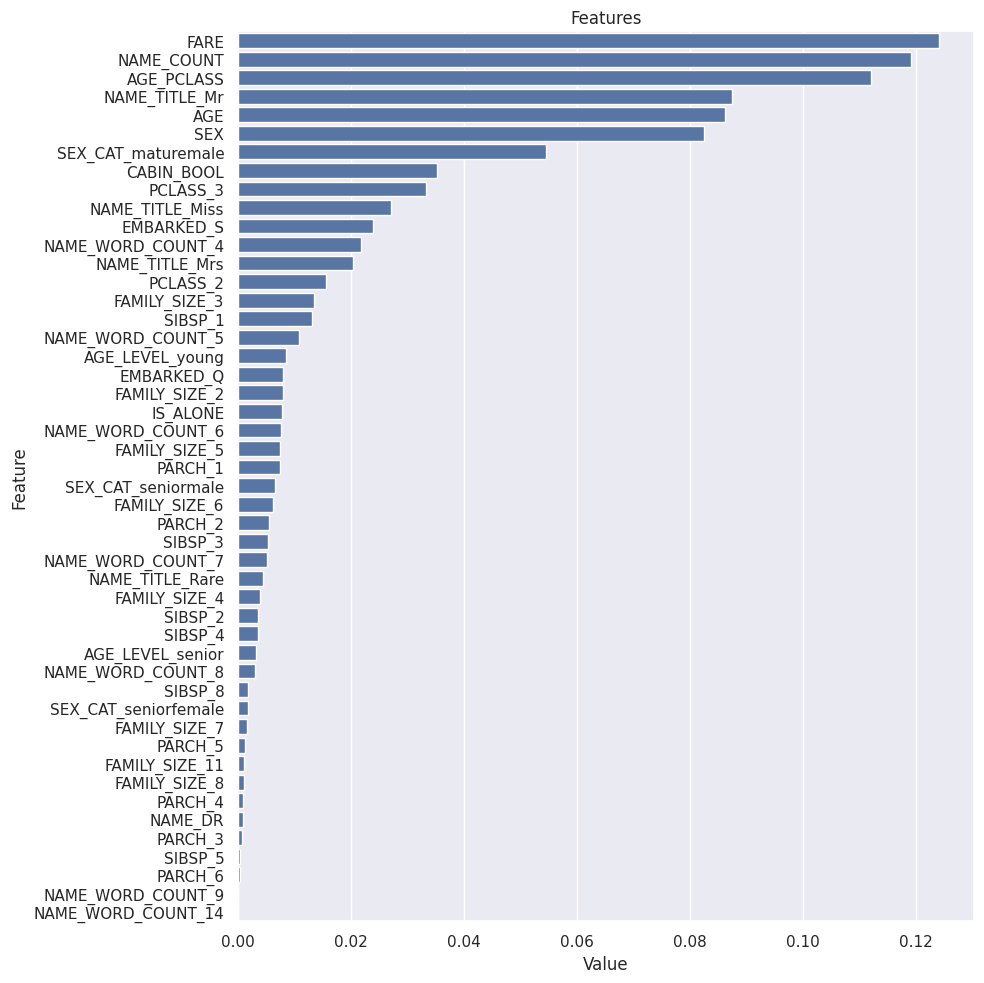

In [ ]:
plot_importance(rf_model, x_train)